In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('..')
import pandas as pd
import numpy as np
import hydroeval
from src import load_data, evaluate
import netCDF4 as nc
import pickle
from matplotlib import pyplot as plt
from matplotlib import dates
import datetime as dt
import tikzplotlib

In [2]:
vic_predictions = pd.read_csv('../data/GRIP-E_Hydrographs_VIC-GRU_test2013+2014.csv').drop(['time', 'hour', 'precip [mm/day]'], axis=1)
subid2gauge = pd.read_csv('../data/VIC-GRU_subid2gauge.csv')[['SubId', 'ID']].set_index('SubId')

vic_predictions = vic_predictions.rename(lambda c: subid2gauge.loc[int(c[3:6])].values[0] if c not in ['date', 'hour', 'precip [mm/day]'] else c, axis=1)
vic_predictions = vic_predictions.set_index('date').transpose().unstack().reset_index().rename({'level_0': 'date', 'level_1': 'station', 0: 'vic_prediction'}, axis=1)
vic_predictions['date'] = pd.to_datetime(vic_predictions['date'])

In [3]:
xgb_predictions = pickle.load(open('../pickle/results/XGBoost_VIC_aggregateForcings_20190706-082538.pkl','rb'))
xgb_predictions = xgb_predictions.drop(['actual'], axis=1).rename({'prediction': 'xgb_prediction'}, axis=1)

In [4]:
ground_truth = load_data.load_discharge_gr4j_vic()
ground_truth = ground_truth[~pd.isna(ground_truth['runoff'])]

../src/load_data.py:20: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  data = pd.read_csv(os.path.join(dir, f), skiprows=2, skipfooter=1, index_col=False, header=None, names=['runoff'], na_values='-1.2345')
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [5]:
data = pd.merge(ground_truth, vic_predictions, on=['date', 'station'])
data = pd.merge(data, xgb_predictions, on=['date', 'station'])
data = data[data['date'] > '2012-12-31']

/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
../src/evaluate.py:41: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../src/evaluate.py:41: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

XGB outperforms VIC in 39 of the stations
XGB almost outperforms VIC in 44 of the stations (tol 0.07)
VIC Median NSE (clipped to 0) 0.29637631572655176 / Min -11.895232728334562 / Max 0.6231629725173315
XGB Median NSE (clipped to 0) 0.5222957762280172 / Min -0.20600531332203498 / Max 0.666221324763711
VIC Median MSE (clipped to 0) 130.92244483980326 / Min 11.835217235911124 / Max 26680.343897637427
XGB Median MSE (clipped to 0) 96.82126751132567 / Min 2.9515256400193297 / Max 31010.79787935949


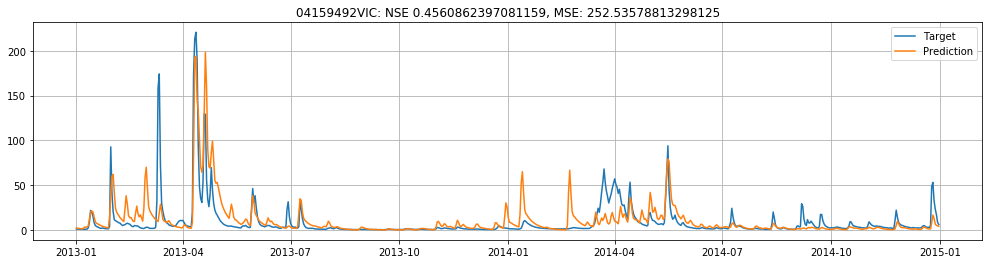

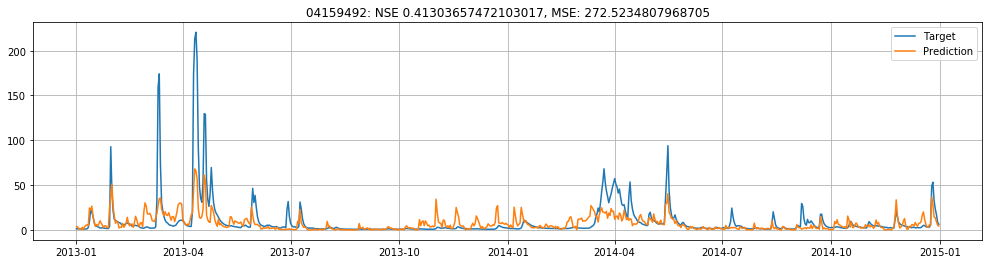

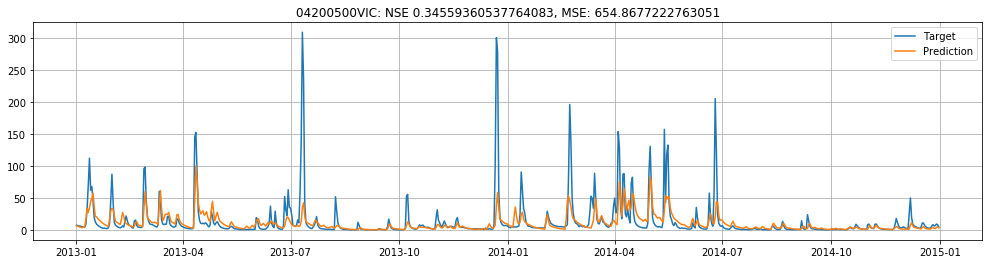

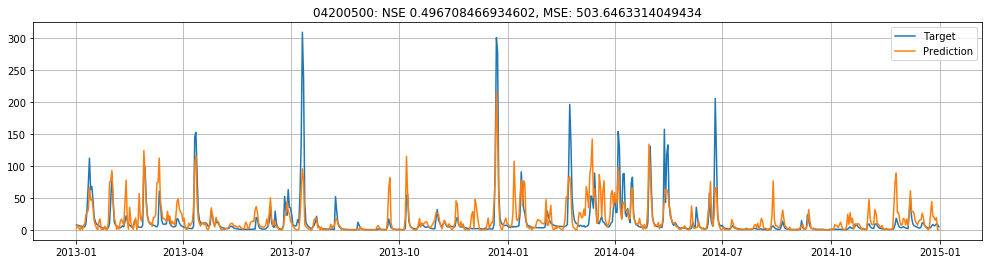

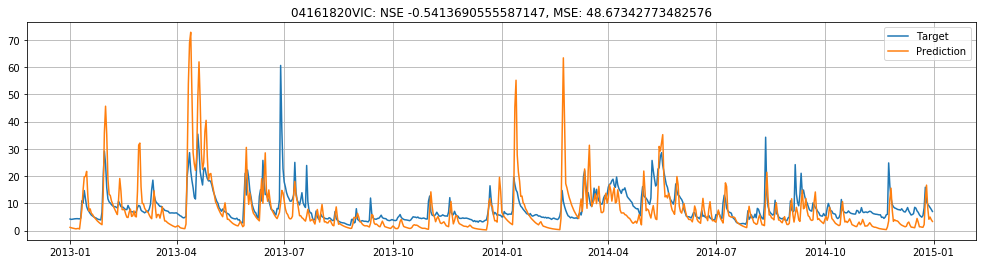

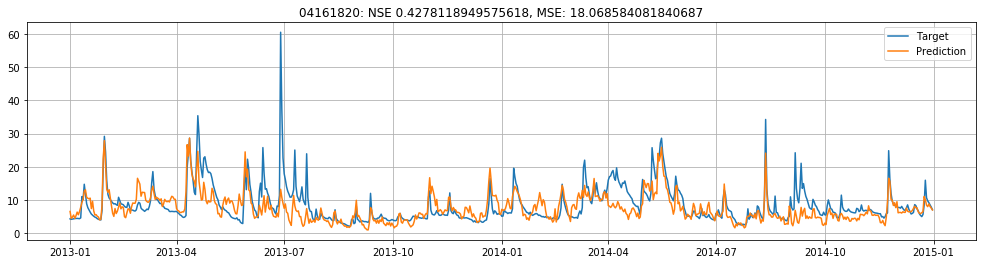

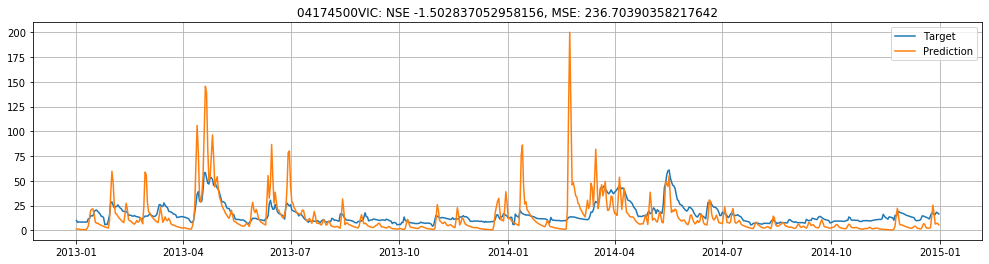

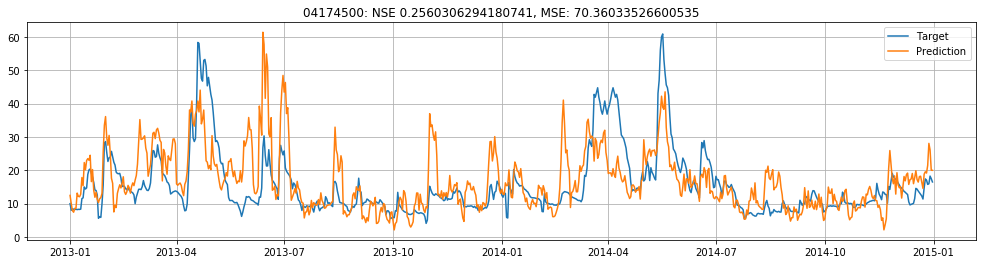

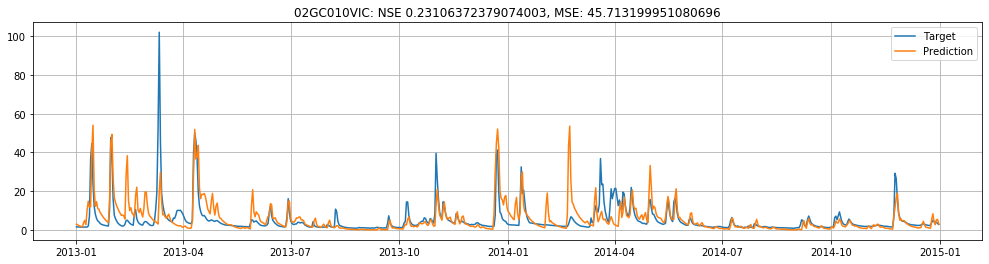

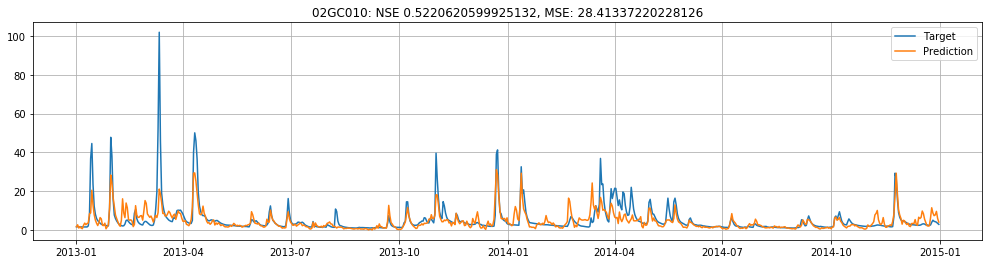

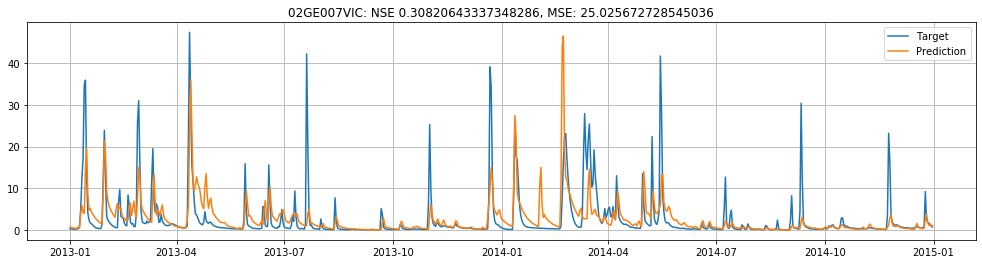

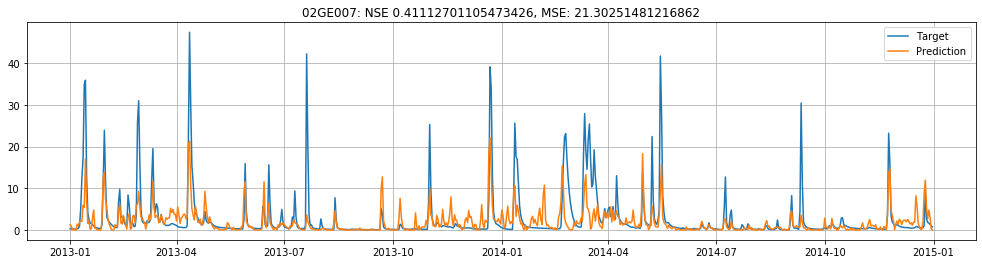

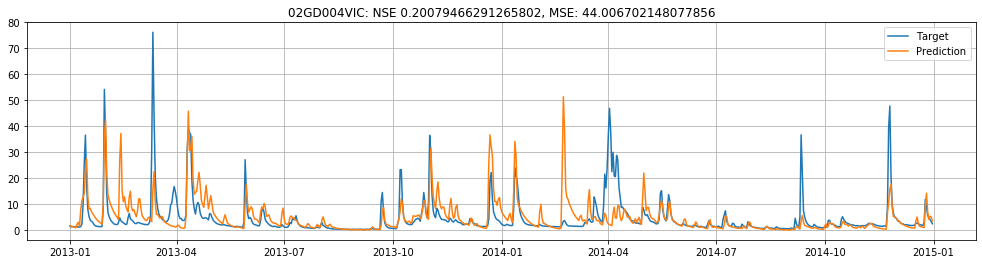

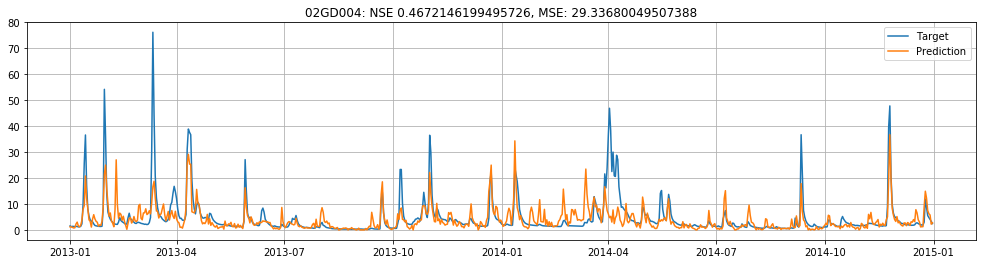

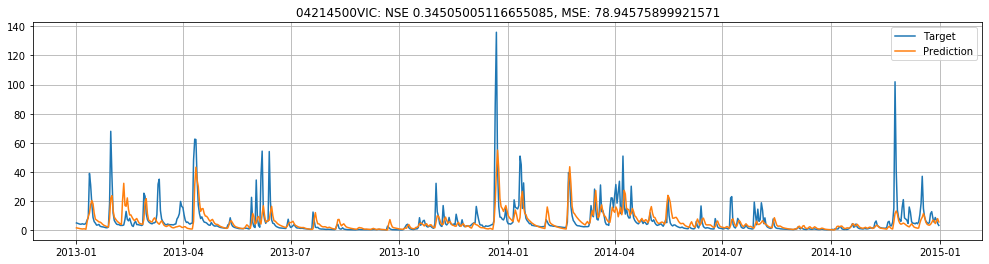

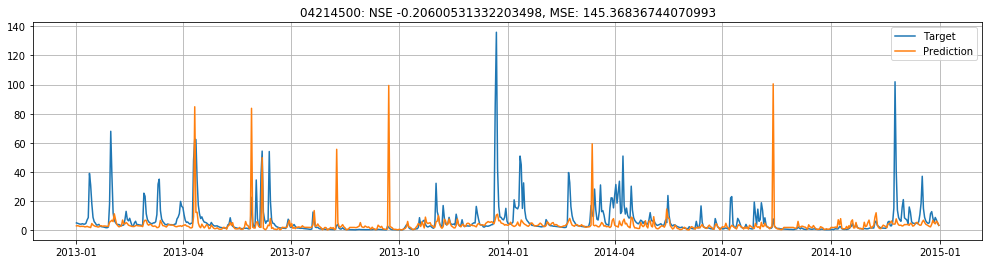

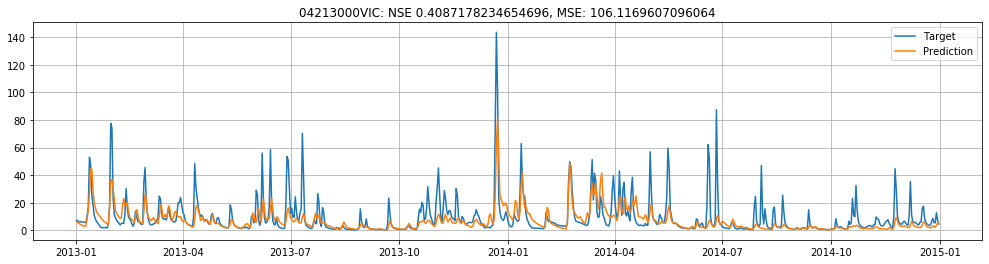

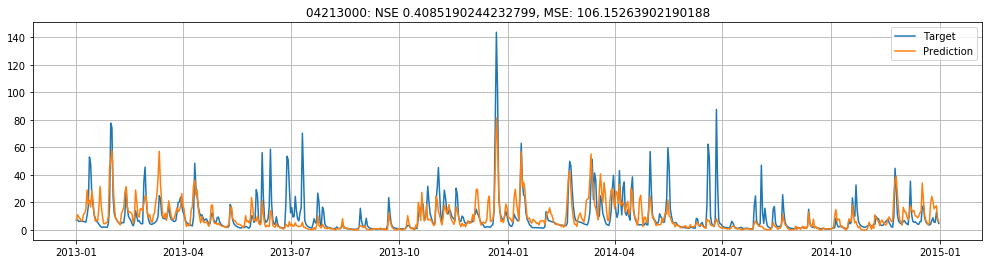

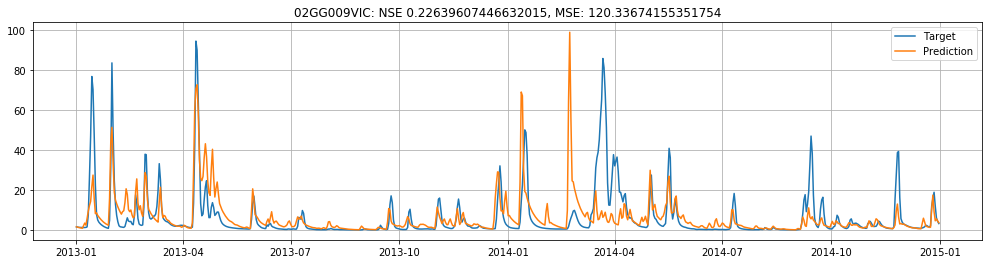

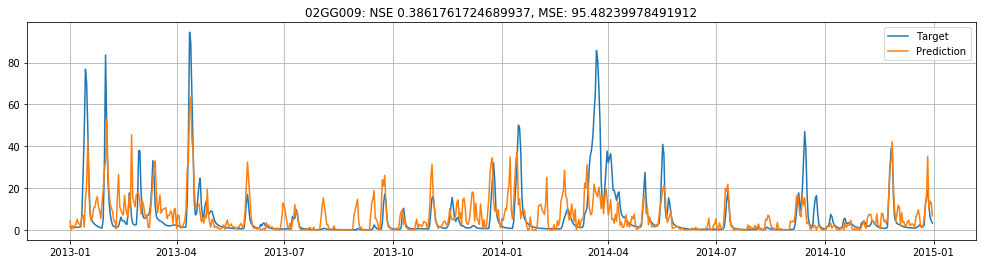

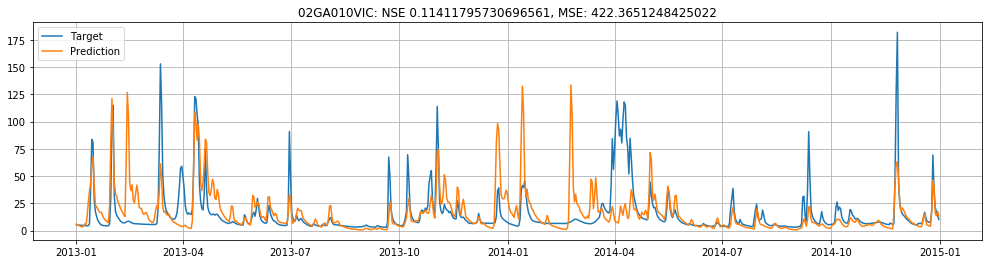

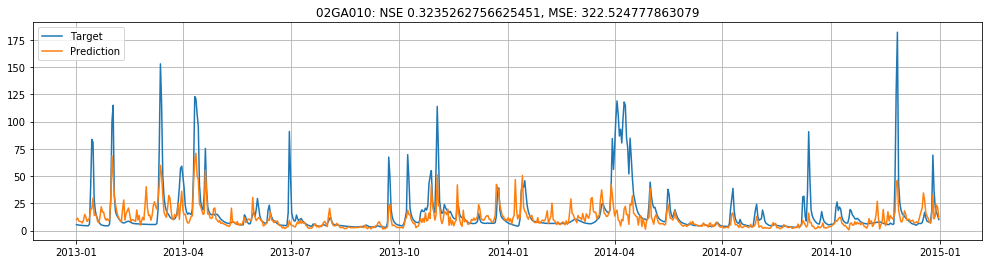

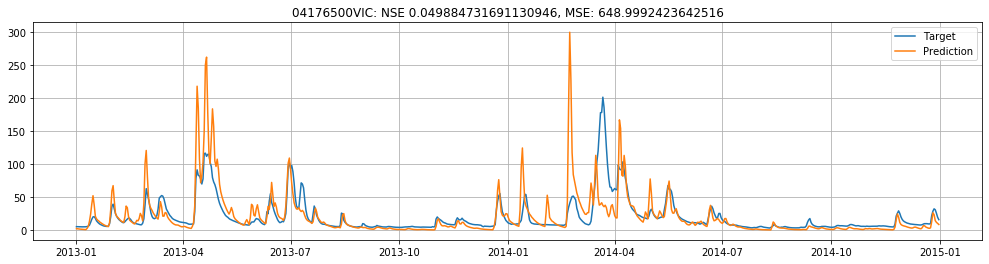

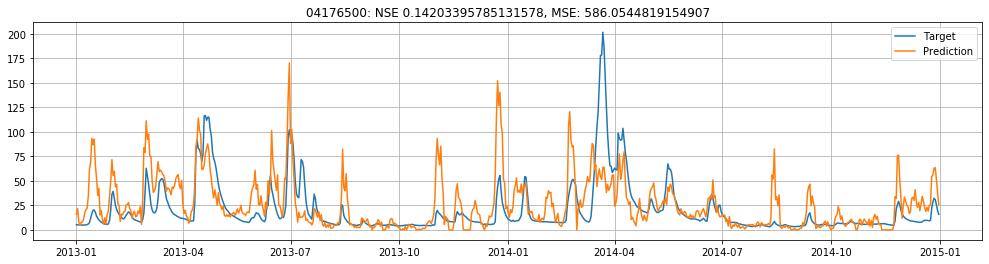

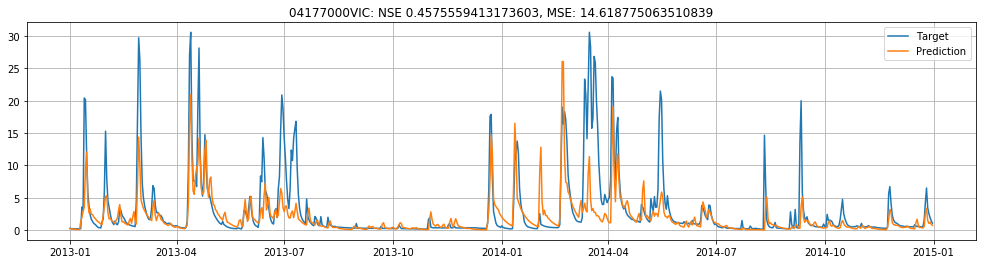

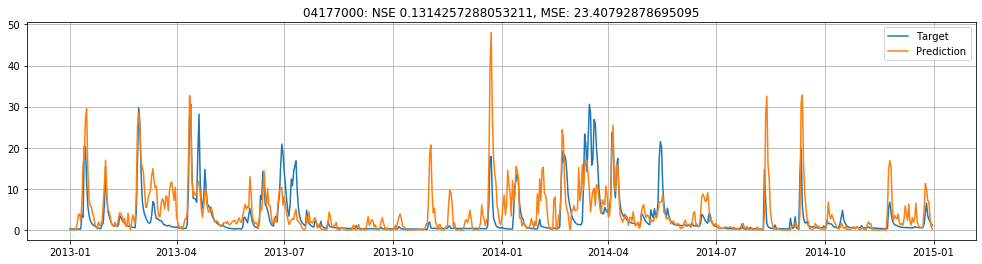

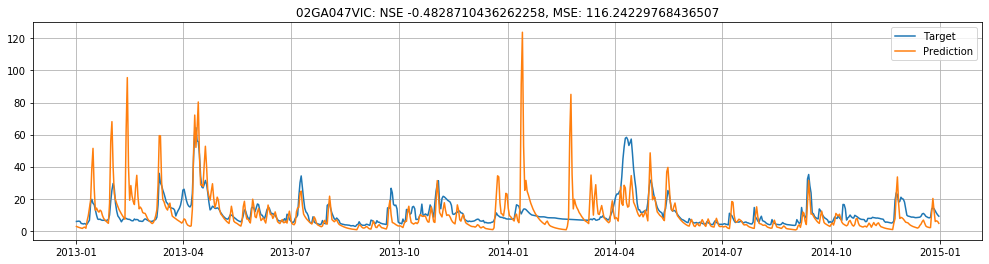

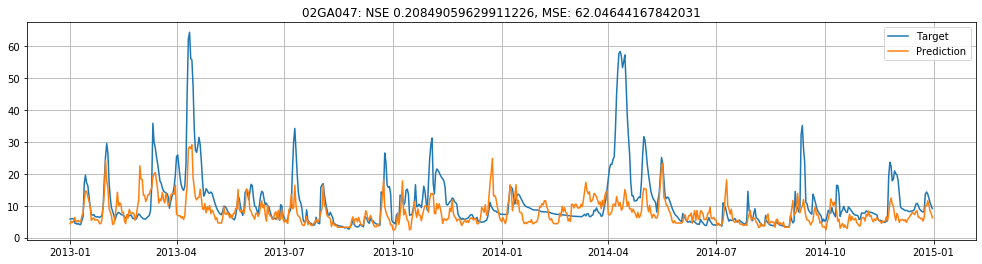

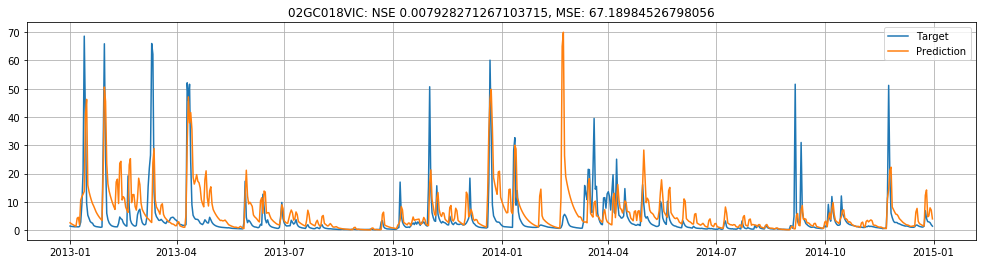

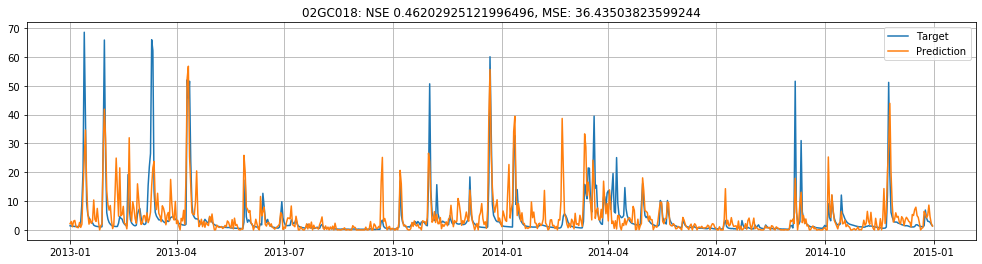

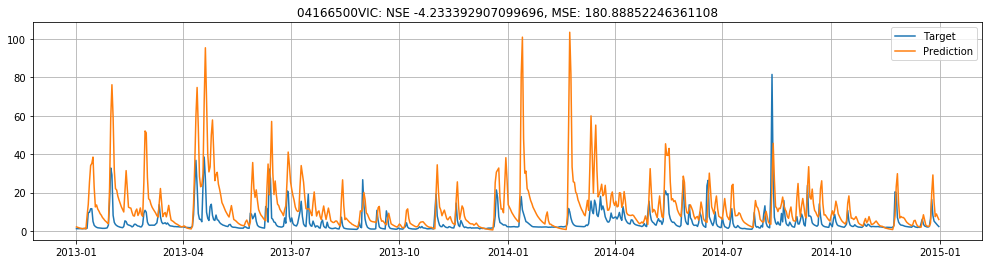

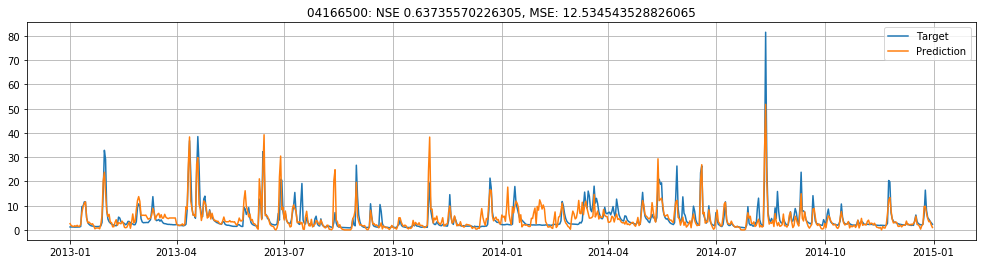

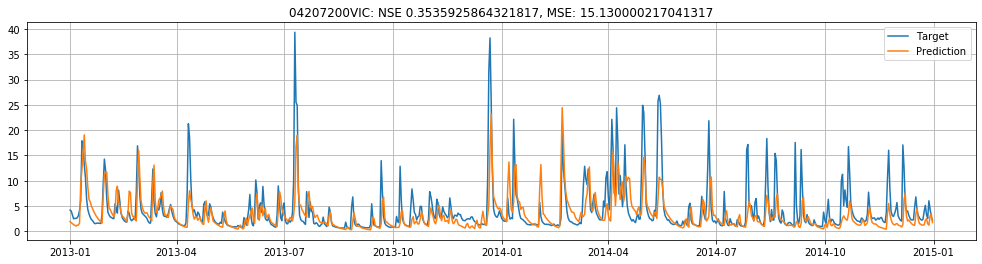

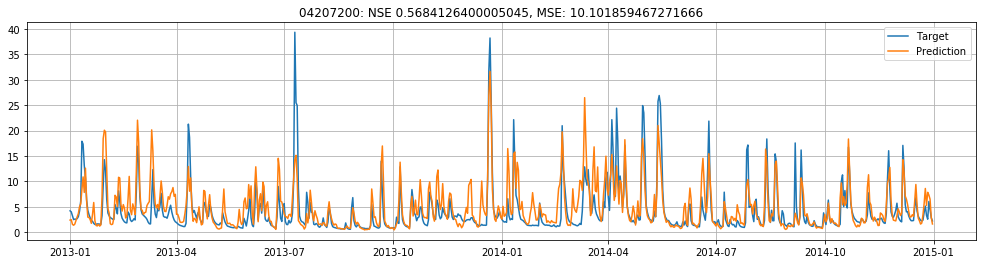

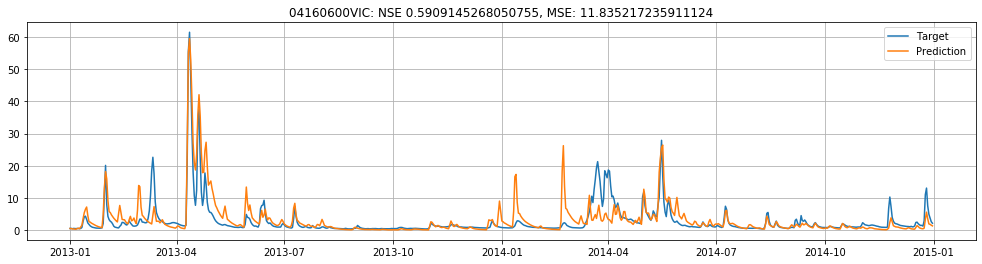

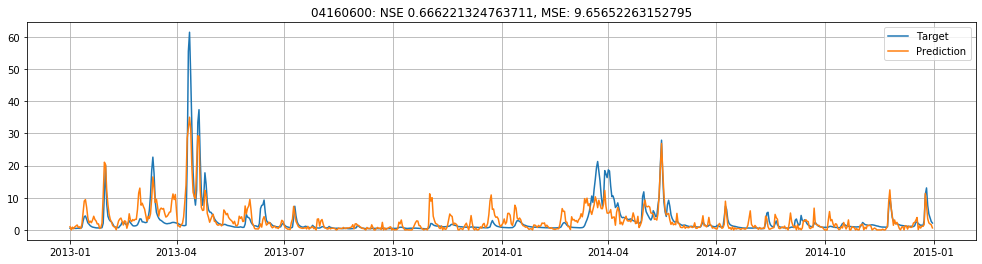

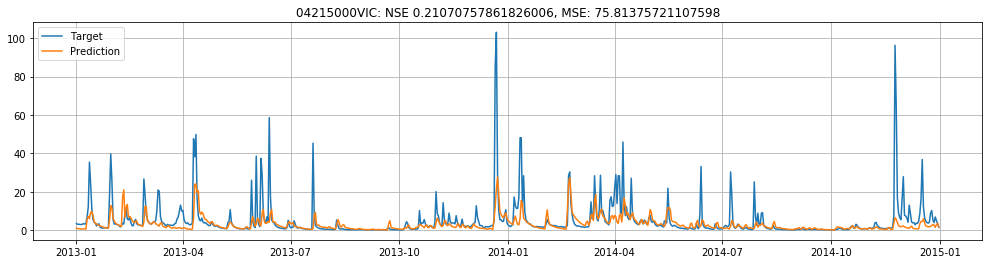

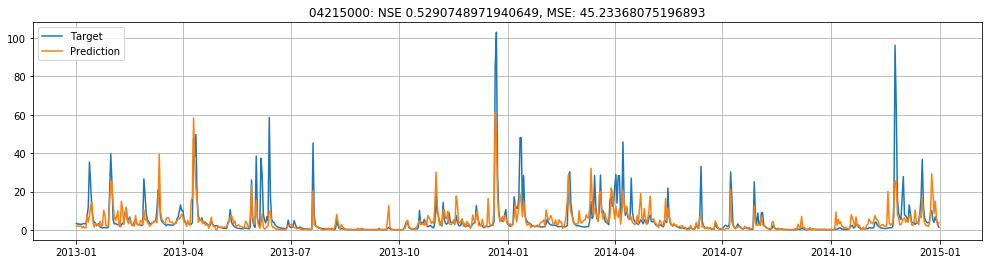

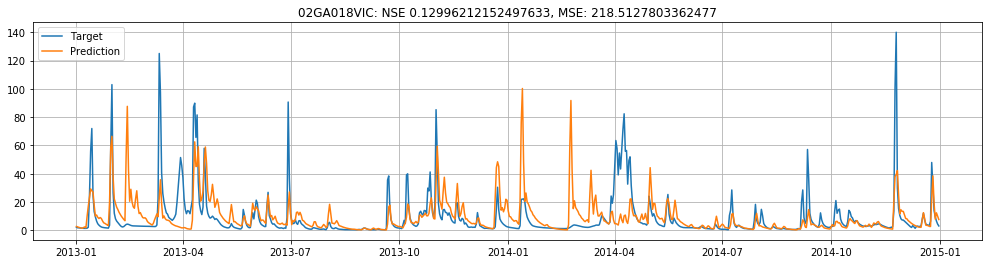

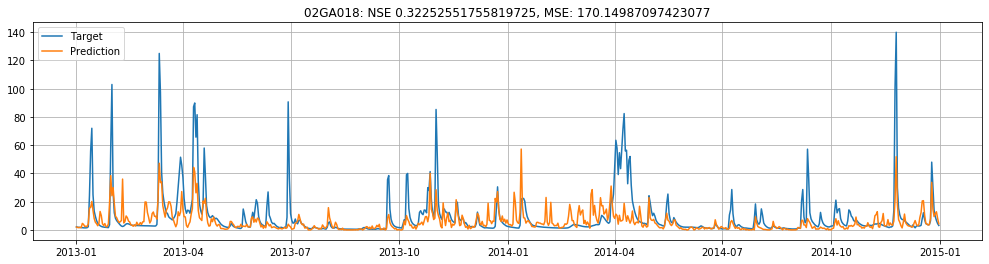

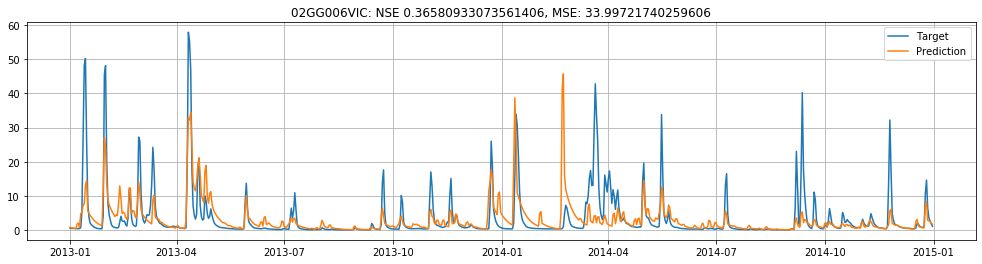

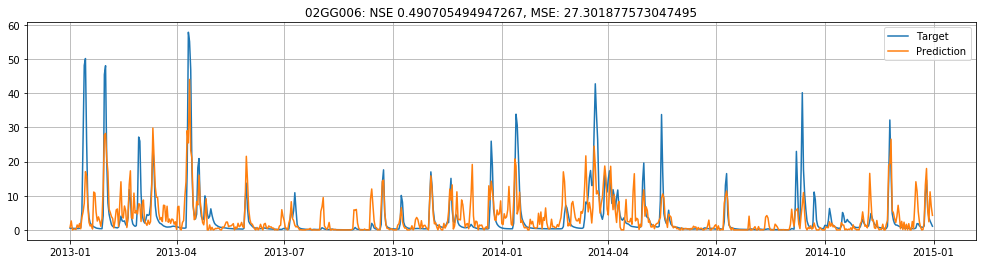

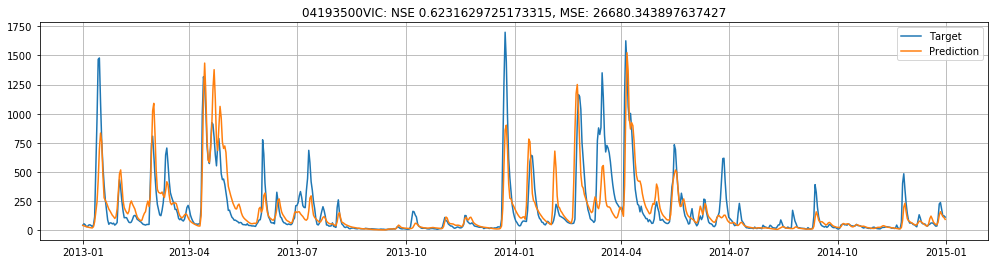

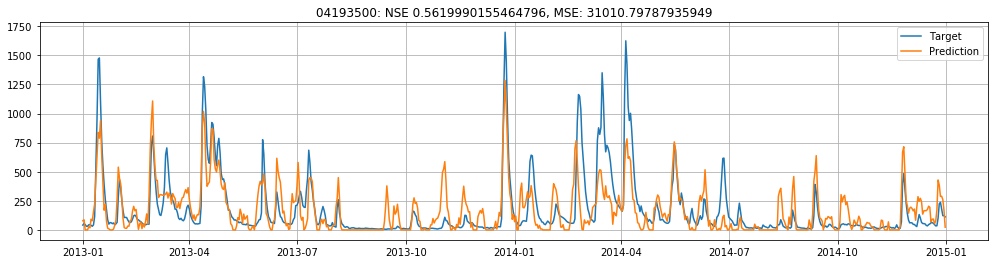

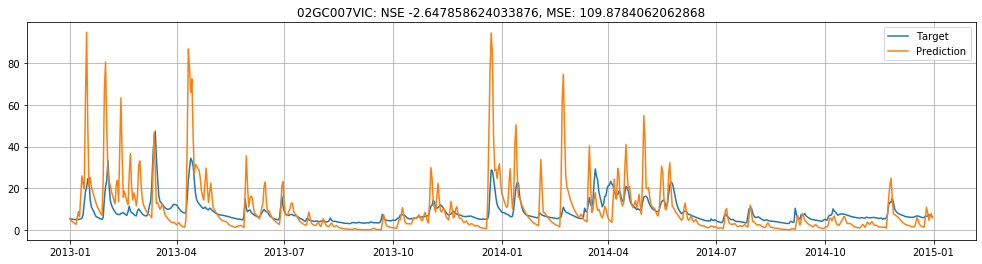

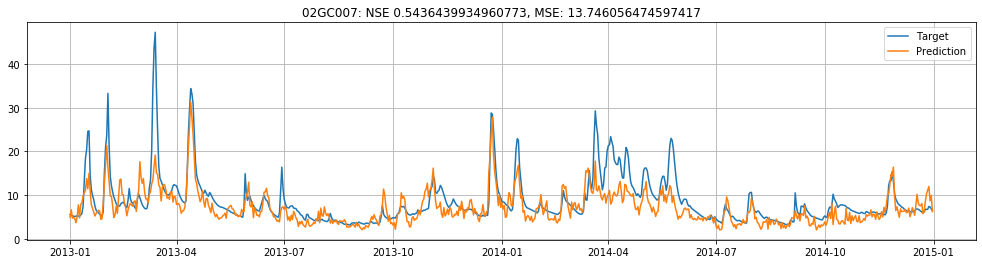

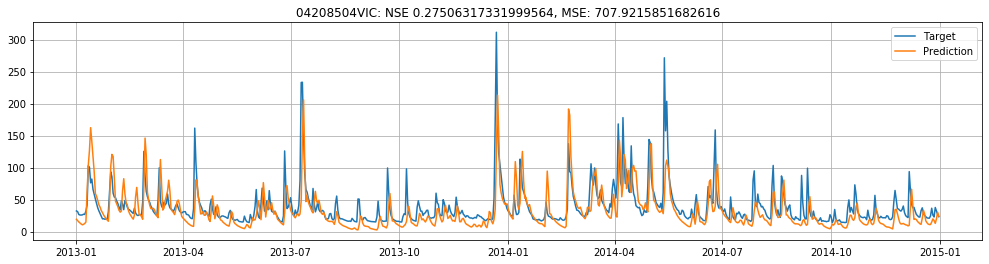

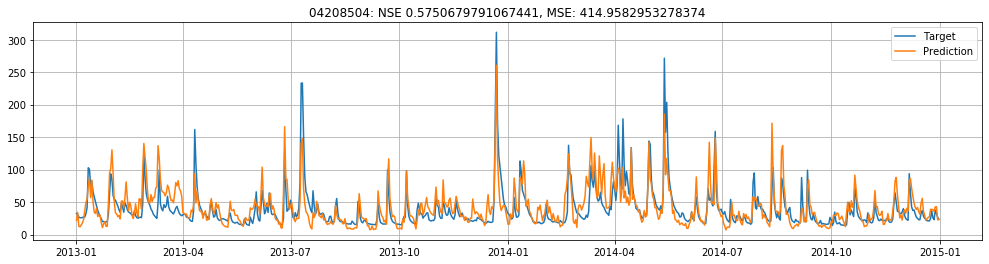

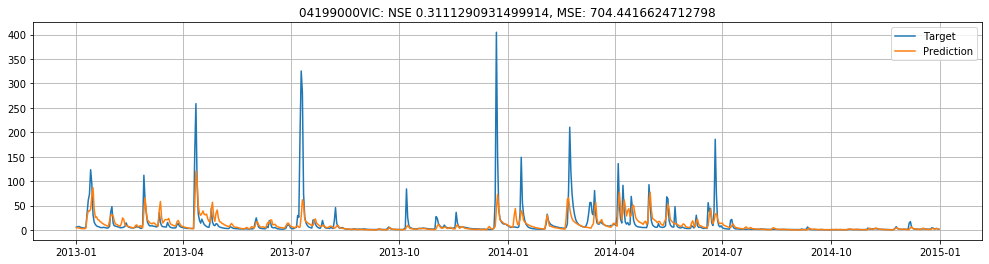

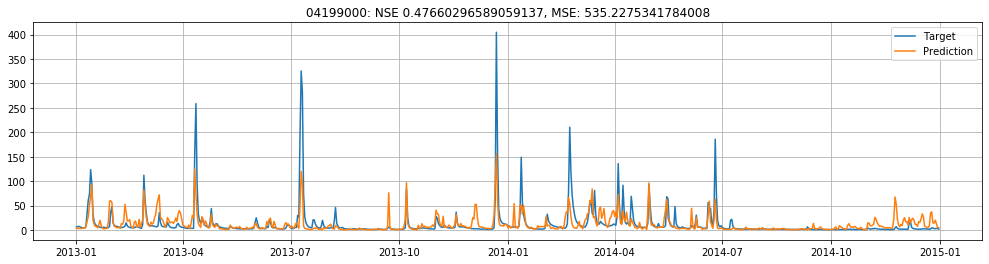

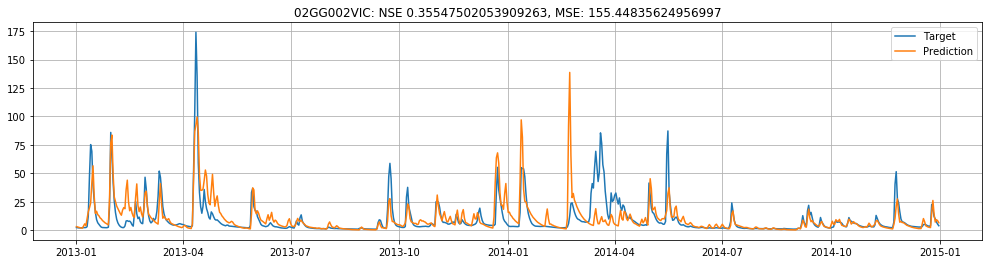

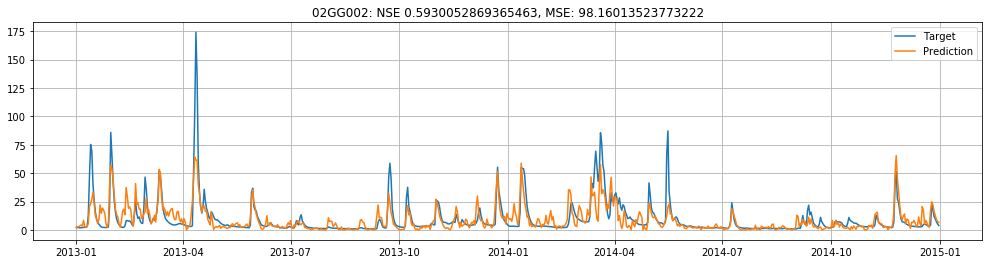

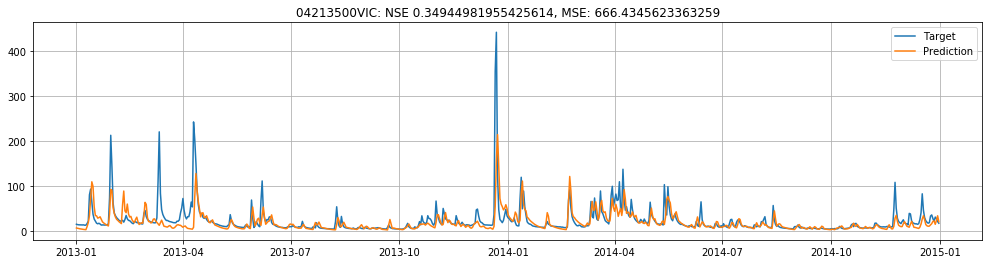

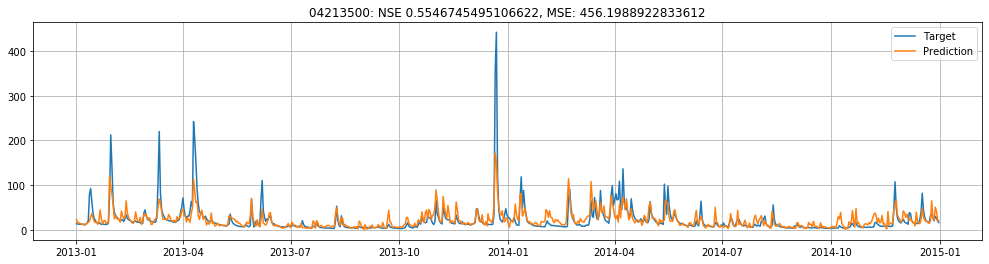

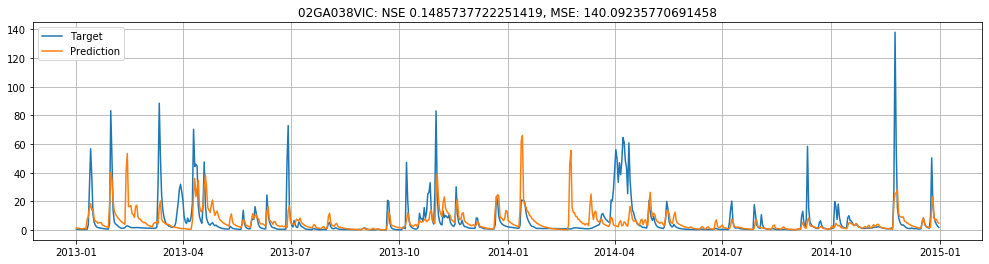

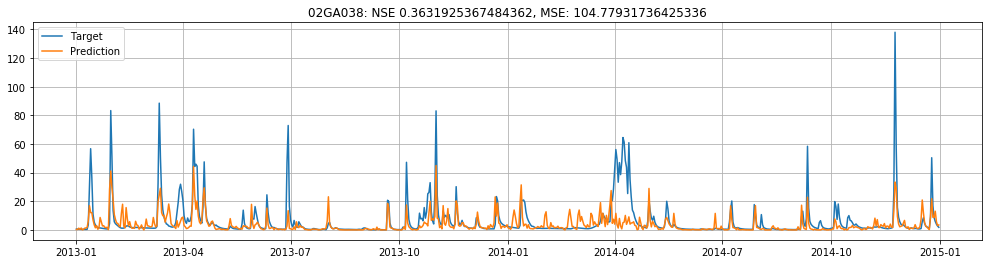

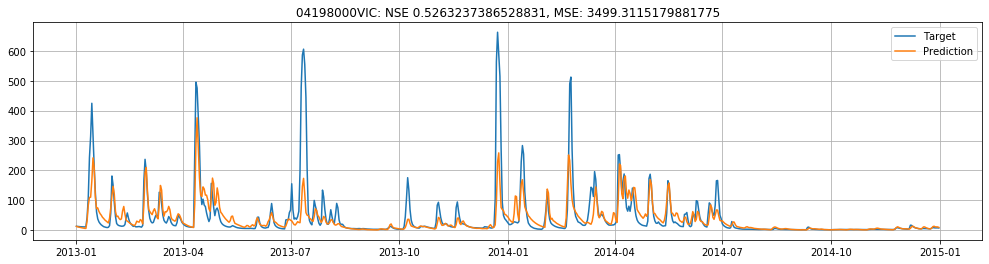

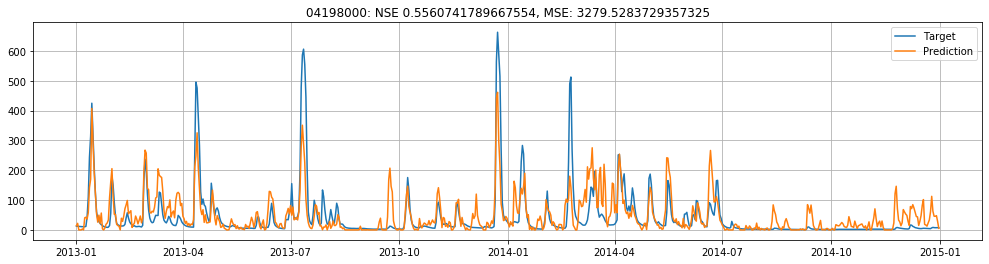

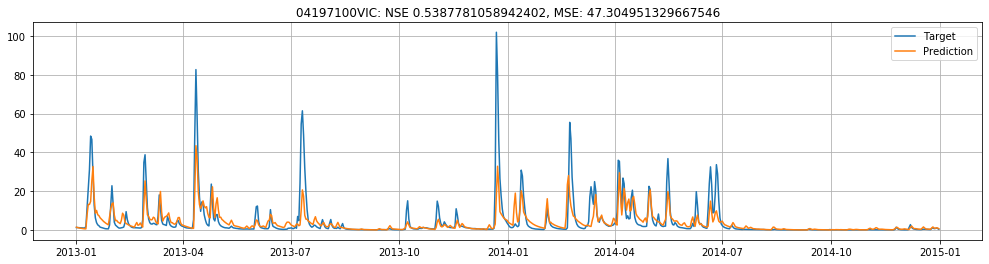

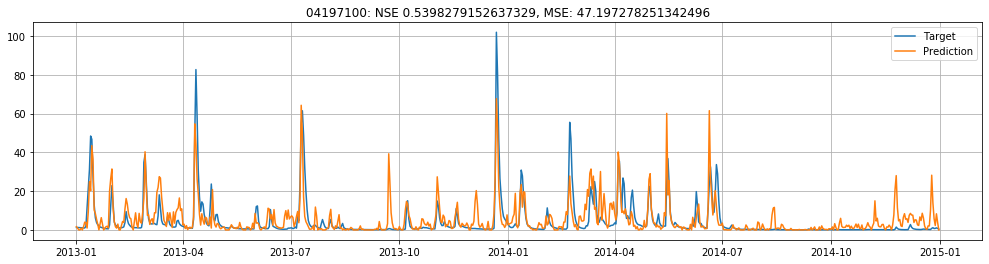

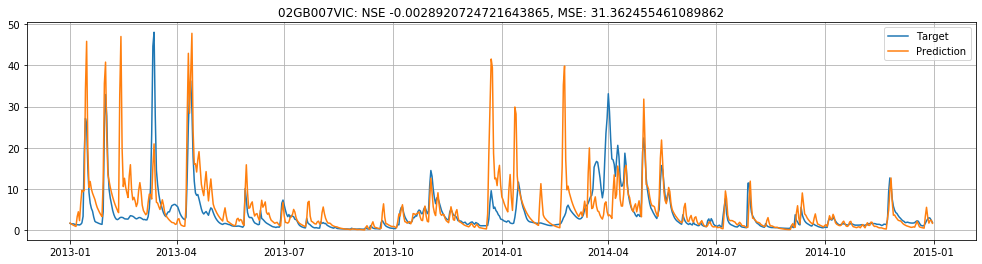

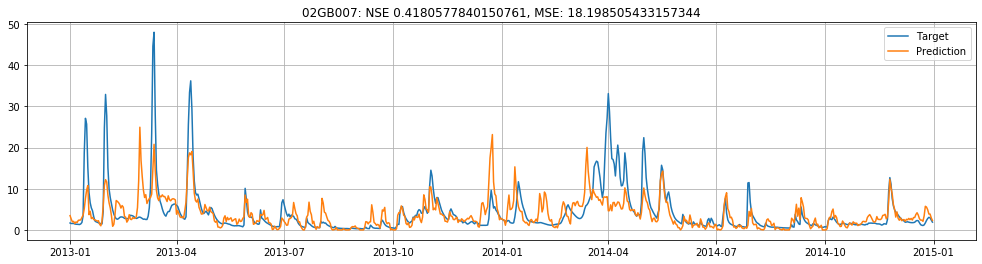

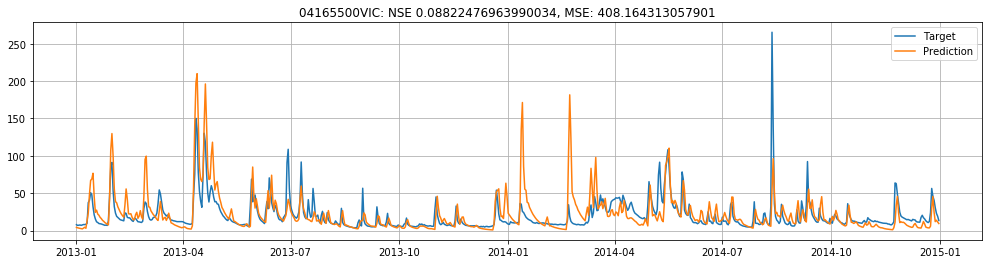

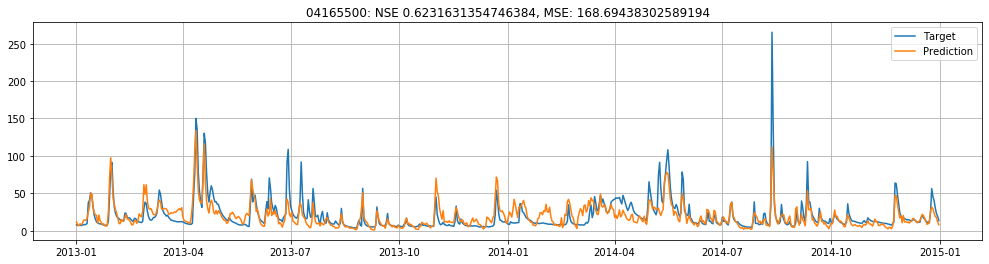

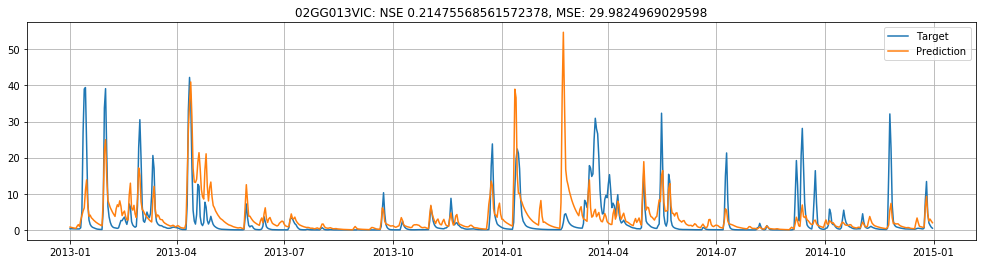

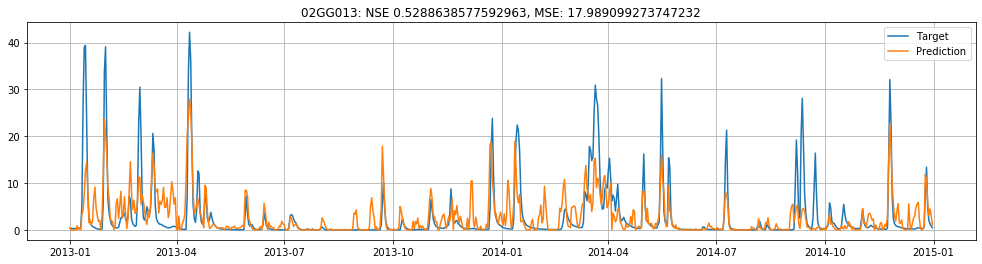

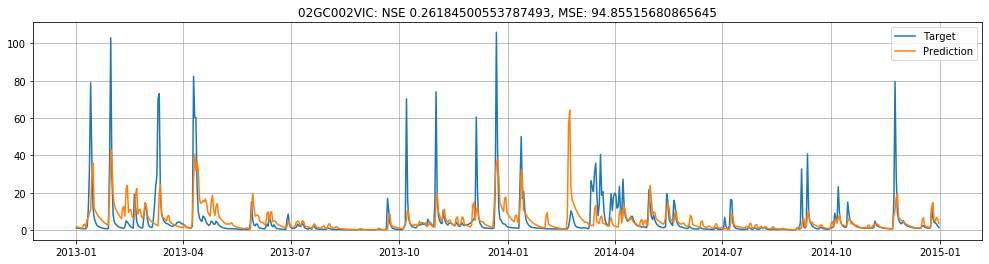

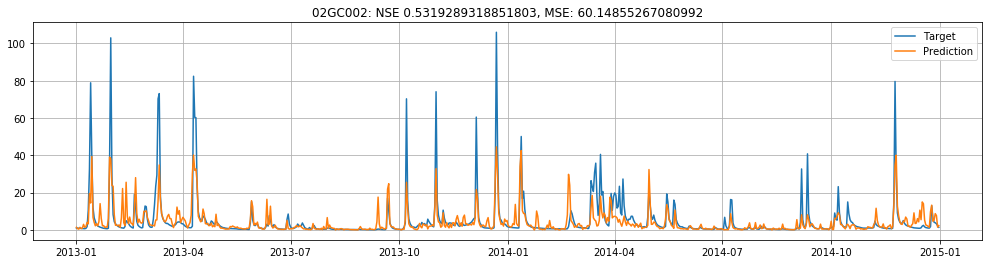

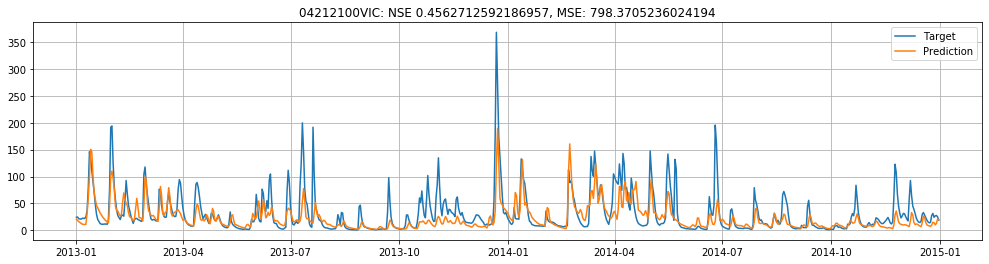

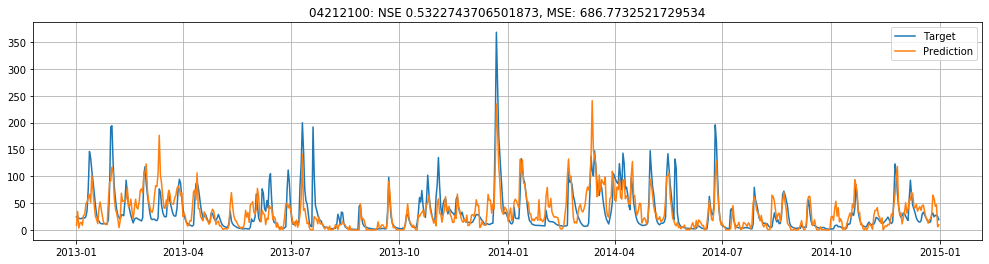

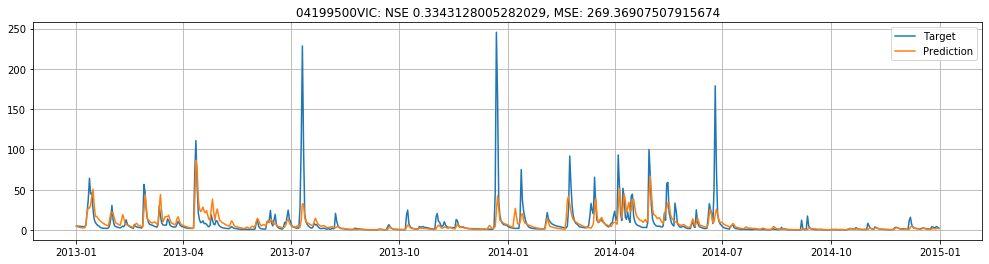

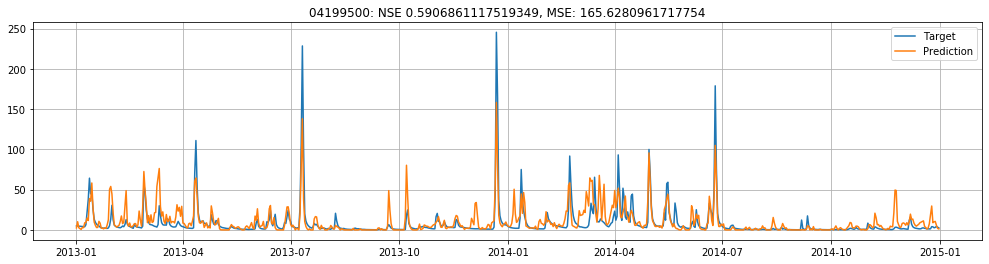

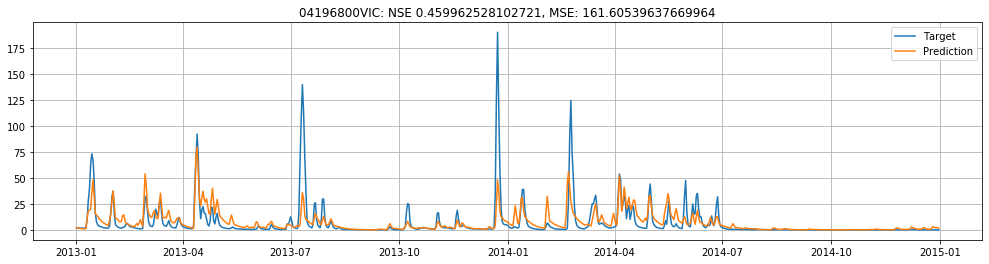

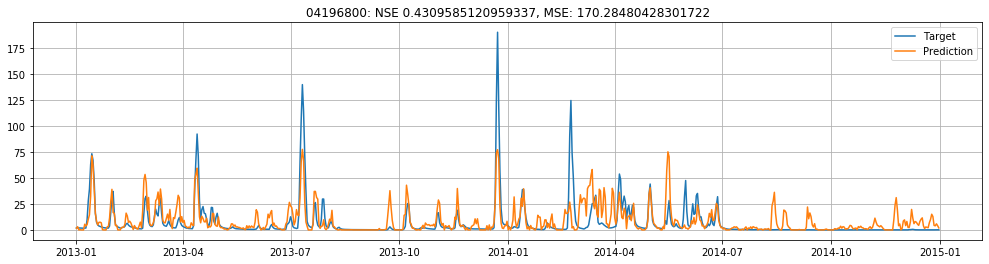

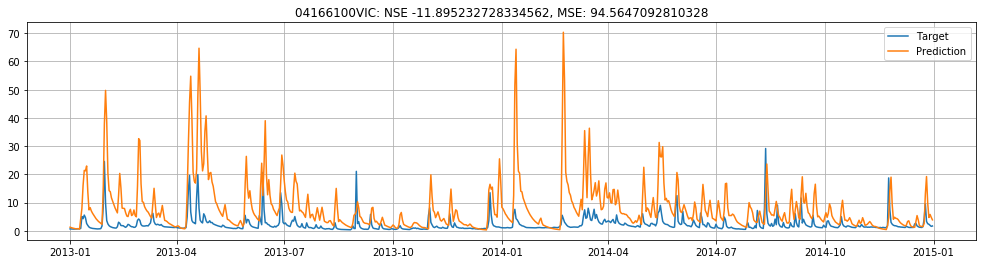

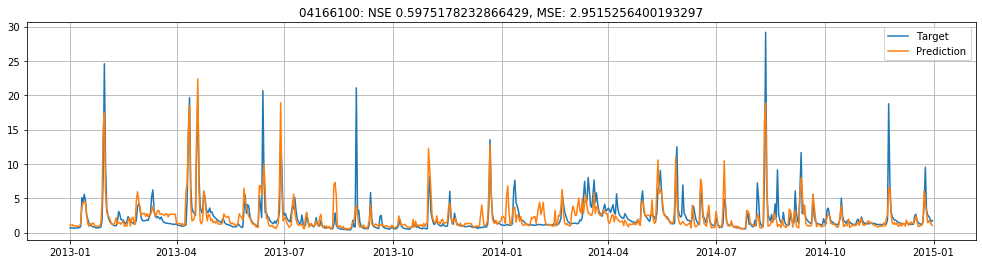

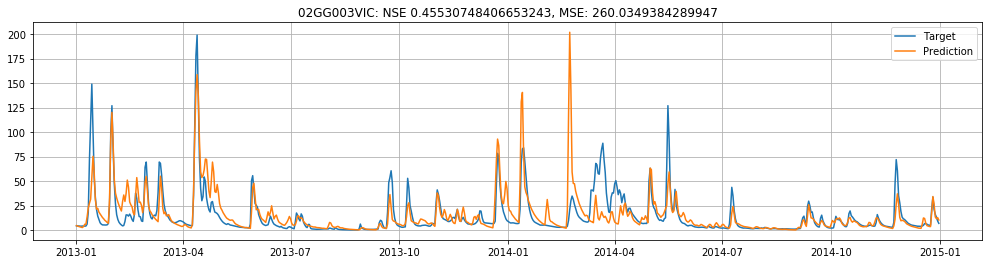

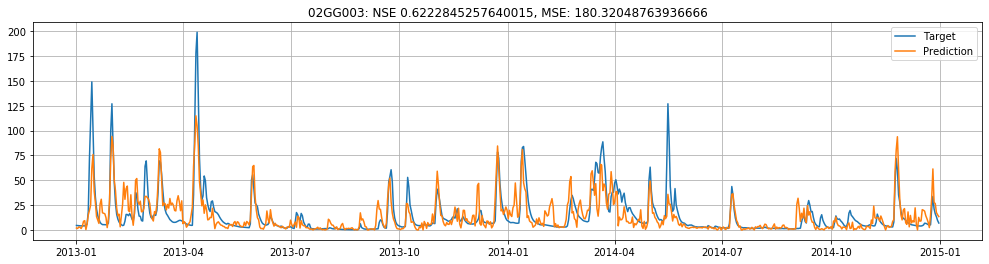

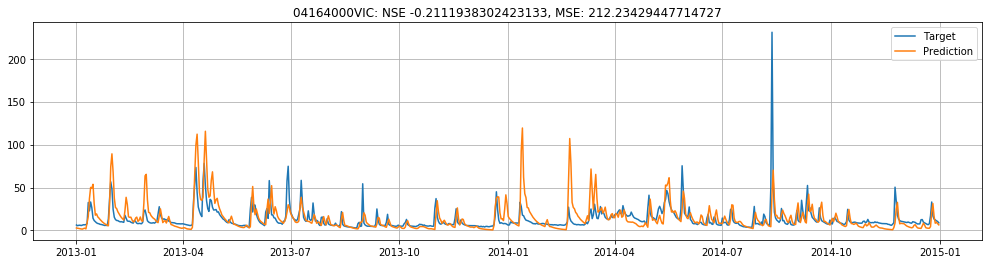

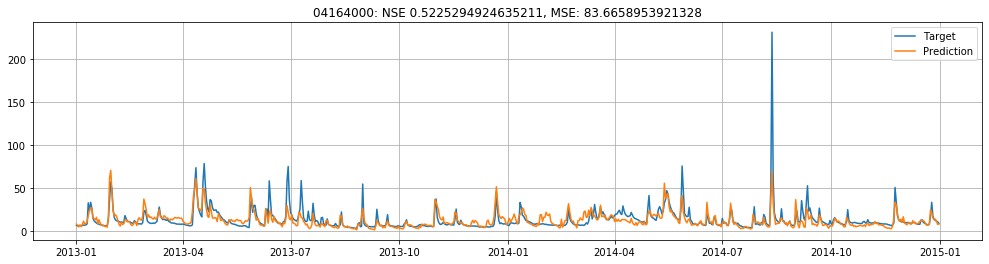

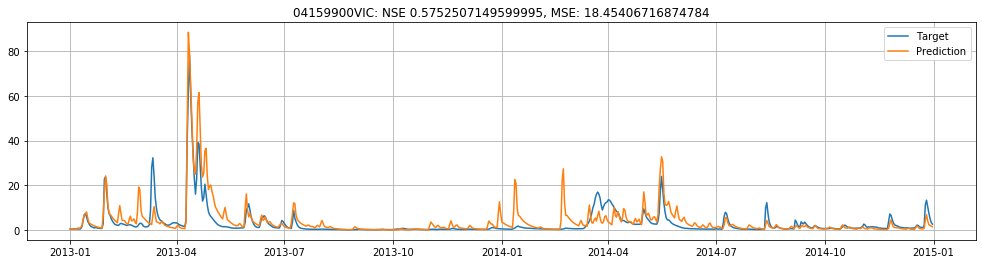

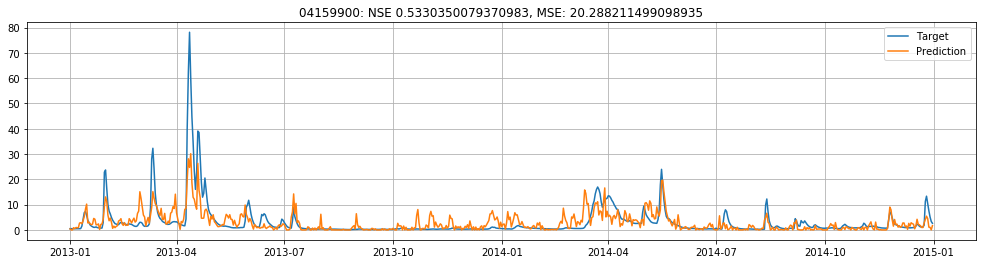

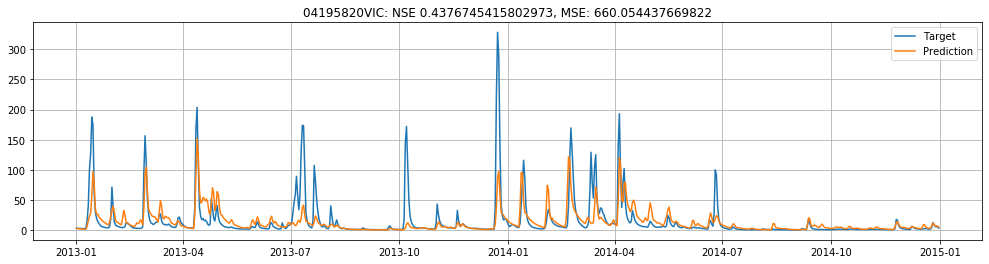

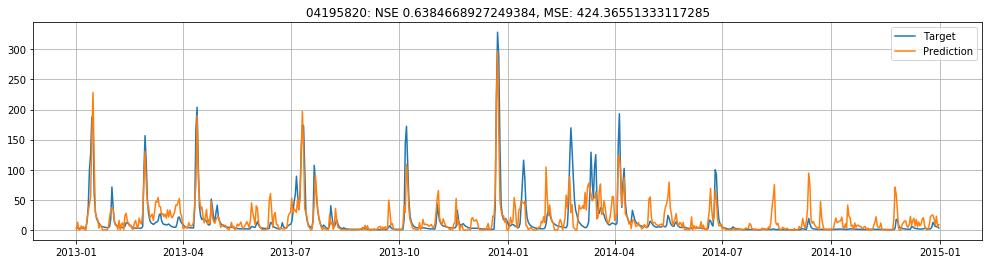

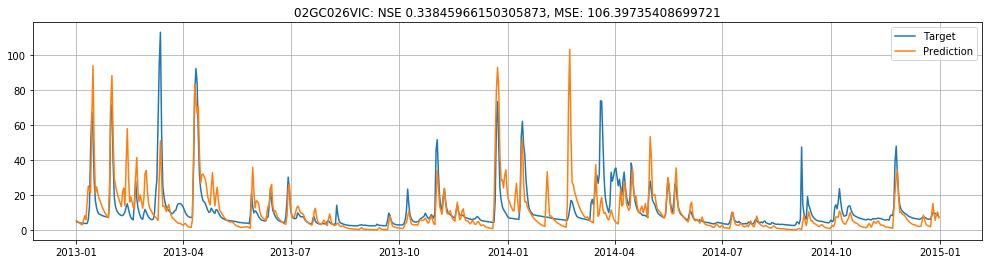

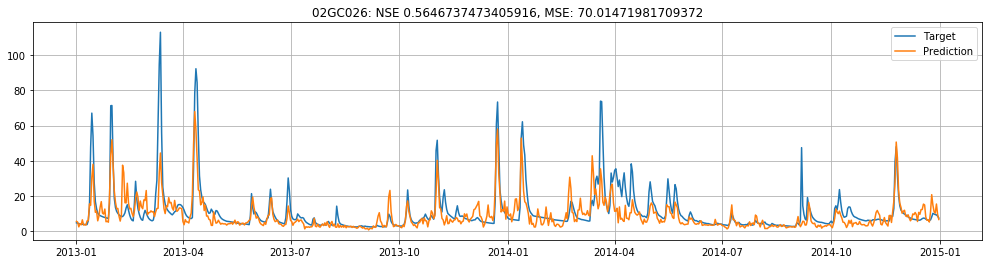

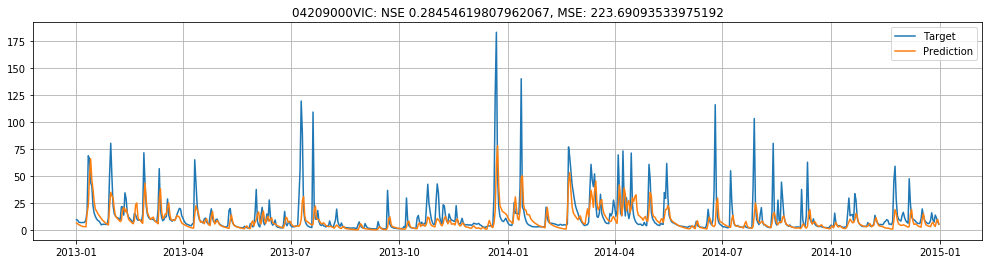

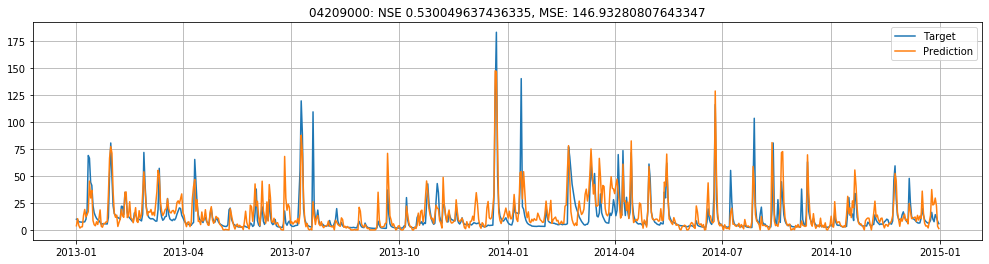

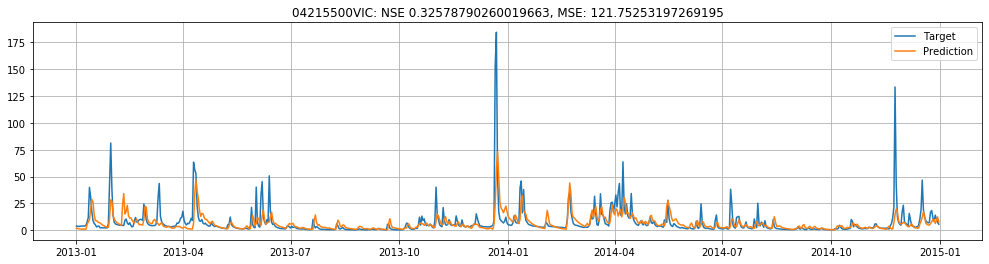

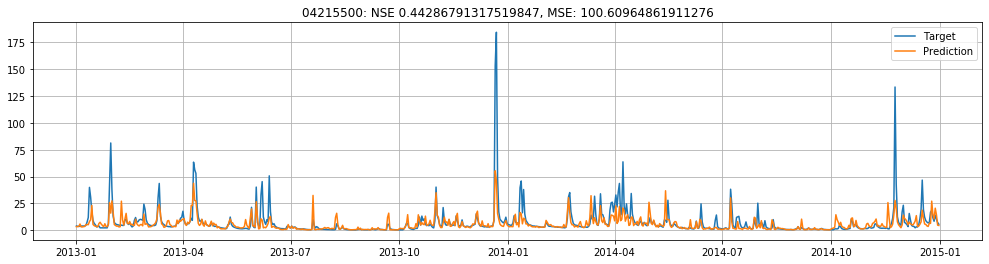

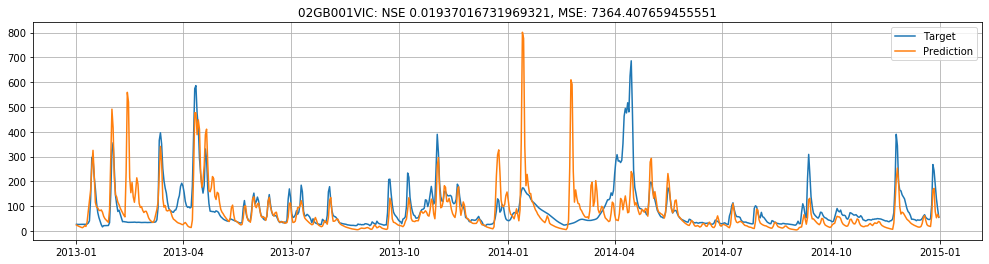

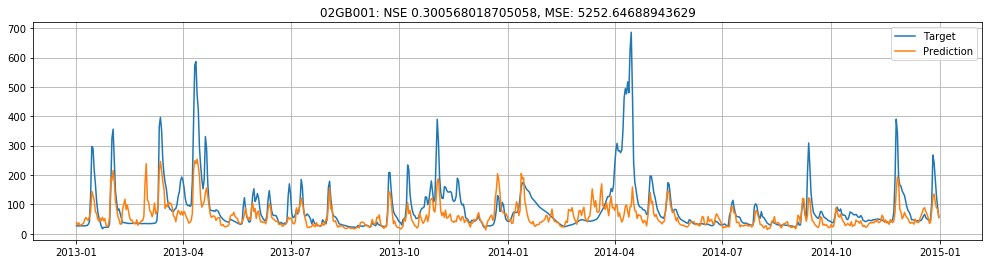

In [6]:
plot_list = []
vic_nse_list, vic_mse_list = [], []
xgb_nse_list, xgb_mse_list = [], []
xgb_larger, xgb_almost_larger = 0, 0
tol = 0.07
for station in data['station'].unique():
    station_data = data[data['station']==station].set_index('date')
    
    vic_nse, vic_mse = evaluate.evaluate_daily(station+'VIC', station_data[['vic_prediction']], station_data['runoff'], plot=True)#station in plot_list)
    xgb_nse, xgb_mse = evaluate.evaluate_daily(station, station_data[['xgb_prediction']], station_data['runoff'], plot=True)#station in plot_list)
    vic_nse_list.append(vic_nse)
    vic_mse_list.append(vic_mse)
    xgb_nse_list.append(xgb_nse)
    xgb_mse_list.append(xgb_mse)
    if xgb_nse > vic_nse:
        xgb_larger += 1
    if xgb_nse > vic_nse - tol:
        xgb_almost_larger += 1

print('XGB outperforms VIC in {} of the stations'.format(xgb_larger))
print('XGB almost outperforms VIC in {} of the stations (tol {})'.format(xgb_almost_larger, tol))
print('VIC Median NSE (clipped to 0)', np.median(vic_nse_list), '/ Min', np.min(vic_nse_list), '/ Max', np.max(vic_nse_list))
print('XGB Median NSE (clipped to 0)', np.median(xgb_nse_list), '/ Min', np.min(xgb_nse_list), '/ Max', np.max(xgb_nse_list))
print('VIC Median MSE (clipped to 0)', np.median(vic_mse_list), '/ Min', np.min(vic_mse_list), '/ Max', np.max(vic_mse_list))
print('XGB Median MSE (clipped to 0)', np.median(xgb_mse_list), '/ Min', np.min(xgb_mse_list), '/ Max', np.max(xgb_mse_list))

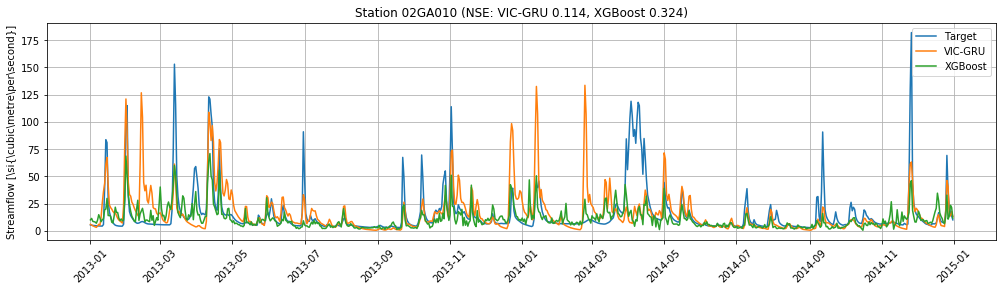

In [7]:
station = '02GA010'
station_data = data[data['station']==station].set_index('date')

vic_nse, _ = evaluate.evaluate_daily(station, station_data[['vic_prediction']], station_data['runoff'], plot=False)
xgb_nse, _ = evaluate.evaluate_daily(station, station_data[['xgb_prediction']], station_data['runoff'], plot=False)

f = plt.figure(figsize=(17,4))
plt.title('Station {} (NSE: VIC-GRU {:.3f}, XGBoost {:.3f})'.format(station, vic_nse, xgb_nse))

plt.plot(range(len(station_data)), station_data['runoff'], label='Target')
plt.plot(range(len(station_data)), station_data['vic_prediction'].clip(0), label='VIC-GRU')
plt.plot(range(len(station_data)), station_data['xgb_prediction'].clip(0), label='XGBoost')
plt.ylabel('Streamflow [\si{\cubic\metre\per\second}]')
plt.grid()
plt.legend()

dates = pd.Series(pd.date_range('2013-01-01', '2015-01-01', freq='D'))
xticks = dates[dates.dt.day==1][::2]
plt.xticks(ticks=xticks.index.values, labels=xticks.dt.strftime('%Y-%m').values, rotation=45)

tikzplotlib.save('../figures/02GA010_vic-gru_xgboost20190706-082538_2013-2014.tex', figureheight='\\figureheight', figurewidth='\\figurewidth')

In [8]:
print(pd.DataFrame([vic_nse_list, xgb_nse_list], index=['VIC-GRU', 'XGBoost']).transpose().describe())

         VIC-GRU    XGBoost
count  46.000000  46.000000
mean   -0.202947   0.461663
std     1.956166   0.161742
min   -11.895233  -0.206005
25%     0.094698   0.411604
50%     0.296376   0.522296
75%     0.397991   0.560518
max     0.623163   0.666221
